In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!ls

gdrive	sample_data


In [ ]:
%cd '/content/gdrive/My Drive/Assignment/'

/content/gdrive/My Drive/Assignment


In [ ]:
!ls

annotations  classification_localisation.ipynb	images	resized_image


In [ ]:
# !mkdir resized_image

In [ ]:
!ls

annotations  classification_localisation.ipynb	images	resized_image


**IMPORTING ESSENTIAL LIBRARIES**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tqdm import tqdm
import cv2

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  print(device)
else:
  device = torch.device("cpu")
  print(device)

cuda


In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

**READING THE TRAINVAL DATASET FROM THE TRAIN LIST PROVIDED IN ANNOTATIONS FOLDER**

In [ ]:
data = pd.read_csv('/content/gdrive/My Drive/Assignment/annotations/trainval.txt', delim_whitespace=True,header=None,)
data.columns = ['image', 'CLASS-ID', 'SPECIES', 'BREED ID'] 
data['image'] = data['image'].apply(lambda x : str(x)+'.jpg')

print(data.head())

                image  CLASS-ID  SPECIES  BREED ID
0  Abyssinian_100.jpg         1        1         1
1  Abyssinian_101.jpg         1        1         1
2  Abyssinian_102.jpg         1        1         1
3  Abyssinian_103.jpg         1        1         1
4  Abyssinian_104.jpg         1        1         1


In [ ]:
print(len(data))

3680


**FUNCTION TO READ ALL THE IMAGES**

In [ ]:
def read_image(path):
  #print(path)
  return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

**FUNCTION WHICH READS ALL THE IMAGES FROM THE DATAFRAME CREATED FROM TRAINVAL DATA AND STORES THE IMAGES IN A LIST**

In [ ]:
def create_image_list(data):
  images = data['image']
  image_list = []

  for img in images:
    image_list.append(img)
        
  return image_list

**FUNCTION TO EXTRACT BOUNDING BOX FROM THE XML FILES**

In [ ]:
def extract_bb(anno_path):
    root = ET.parse(anno_path).getroot()
    
    class_name = root.find("./object/name").text

    xmin = int(root.find("./object/bndbox/xmin").text)
    ymin = int(root.find("./object/bndbox/ymin").text)
    xmax = int(root.find("./object/bndbox/xmax").text)
    ymax = int(root.find("./object/bndbox/ymax").text)

    bb = [ymin, xmin, ymax, xmax]
    return bb, class_name

**FUNCTION TO CREATE MASKS FOR BOUNDING BOX FROM THE XML FOLDER PROVIDED**

In [ ]:
def create_mask(bb, image):

  # EXTRACT THE IMAGE SHAPE
  rows, cols = image.shape[:2]

  # CREATE A MATRIX OF ZERO OF THE IMAGE SHAPE
  mask = np.zeros((rows, cols))

  # FILL THE MATRIX CONTAINING THE BOUNDING BOX WITH VALUE 1
  mask[bb[0]:bb[2], bb[1]:bb[3]] = 1.
  return mask


**FUNCTION TO CONVERT RESIZED MASK TO BOUNDING BOX**

In [ ]:
def convert_to_bb(mask):

    # EXTRACT THE SHAPE OF THE MASK OF BOUNDING BOX CREATED
    cols, rows = np.nonzero(mask)

    # RETURN ZERO COORDINATES IF NO MASK
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)

    # EXTRACT THE BOUNDING BOX COORDINATES
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

**FUNCTION TO RESIZE THE IMAGES AND MASKS**

In [ ]:
def image_resize(image_path, new_path, bb):
  size = 300
  image = read_image(image_path)

  # RESIZE THE IMAGE
  image_resized = cv2.resize(image, (int(1.49*size), size))

  # CREATE MASK FROM THE BOUNDING BOX
  mask = create_mask(bb, image)

  # RESIZE THE MASK
  mask_resized = cv2.resize(mask, (int(1.49*size), size))

  # WRITE THE NEW IMAGE INTO ANOTHER FOLDER
  cv2.imwrite(new_path, cv2.cvtColor(image_resized, cv2.COLOR_RGB2BGR))

  return new_path, convert_to_bb(mask_resized)

**FUNCTION TO CREATE DATAFRAME FOR THE FINAL DATASET WITH LABELS AND IMAGES AND BOUNDING BOXES**

In [ ]:
def generate_dataframe(image_list, anno_path, image_path, new_path, size):
  dataset = [ ]
  for image in tqdm(image_list):
    path = image_path + image
    a_path = anno_path + image[:-4] + '.xml'

    # EXTRACT BB AND CLASS_NAME FROM ANNOTATION FILE ABOVE
    bb, class_name = extract_bb(a_path)

    # FILENAME OF THE NEW RESIZED IMAGE
    n_path = new_path + image 

    # RESIZE THE IMAGE AND CORRESPONDING BOUNDING BOX 
    img_path, resized_bb = image_resize(path, n_path, bb)


    # APPENDING EVERYTHING TO A DICTIONARY 
    data_frame = dict()
    data_frame['filename'] = img_path
    data_frame['bb'] = resized_bb
    data_frame['class_name'] = class_name

    dataset.append(data_frame)

  # RETURNING A DATAFRAME FROM THE INFORMATION
  return pd.DataFrame(dataset)

**CREATING THE DATASET**

In [ ]:
import os
image_path = '/content/gdrive/My Drive/Assignment/images/'
anno_path = '/content/gdrive/My Drive/Assignment/annotations/xmls/'
new_path = './resized_image/'

# CREATE IMAGE LIST AND ANNOTATIONS LIST
image_list = create_image_list(data)
annotations = os.listdir(anno_path)

#REMOVING MISS MATCHED DATA FROM ANNOTATIONS AND IMAGES
for img in image_list:
  ann = img[:-4] + '.xml'
  if ann not in annotations:
    image_list.remove(img)

for ann in annotations:
  img = ann[:-4] + '.jpg'
  if img not in image_list:
    annotations.remove(ann)
    
# SHUFFLE THE LIST
np.random.shuffle(image_list)

**CALLING THE DATAFRAME FUNCTION**

In [ ]:
dataframe = generate_dataframe(image_list, anno_path, image_path, new_path, 256)

100%|██████████| 3671/3671 [01:34<00:00, 38.67it/s]


In [ ]:
X = dataframe[['filename', 'bb']]
Y = dataframe['class_name']

# ENCODE THE CLASS NAMES
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

# SPLIT INTO TRAIN AND VALIDATION SETS
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=0)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(2936, 2) (2936,) (735, 2) (735,)


In [ ]:
label_encoder.inverse_transform([0,1])

array(['cat', 'dog'], dtype=object)

 **VISUALISING SOME IMAGES FROM THE DATASET**

In [ ]:
dataframe.head(-10)

,filename,bb,class_name
0,./resized_image/Bengal_189.jpg,"[107.0, 295.0, 220.0, 403.0]",cat
1,./resized_image/staffordshire_bull_terrier_144...,"[56.0, 90.0, 180.0, 279.0]",dog
2,./resized_image/Egyptian_Mau_110.jpg,"[100.0, 306.0, 196.0, 417.0]",cat
3,./resized_image/american_bulldog_149.jpg,"[106.0, 156.0, 162.0, 273.0]",dog
4,./resized_image/Ragdoll_137.jpg,"[17.0, 113.0, 190.0, 330.0]",cat
...,...,...,...
3656,./resized_image/japanese_chin_166.jpg,"[27.0, 210.0, 168.0, 389.0]",dog
3657,./resized_image/Abyssinian_17.jpg,"[67.0, 61.0, 140.0, 221.0]",cat
3658,./resized_image/staffordshire_bull_terrier_17.jpg,"[56.0, 235.0, 134.0, 311.0]",dog
3659,./resized_image/pomeranian_16.jpg,"[53.0, 135.0, 175.0, 231.0]",dog


**FUNCTION TO PLOT BOUNDING BOX AROUND THE IMAGE**

In [ ]:
def plot_bb(path, bb):
  image = read_image(path)
  bb = np.array(bb, dtype = np.float32)

  rect_box = plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], 
                           color='YELLOW',
                           fill=False, lw=3)
  
  plt.imshow(image)
  plt.gca().add_patch(rect_box)

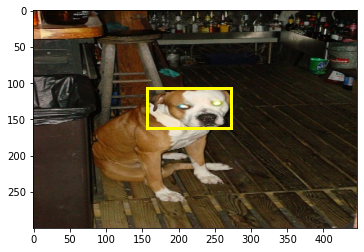

In [ ]:
plot_bb(dataframe['filename'][3], dataframe['bb'][3])

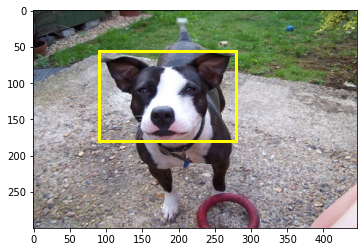

In [ ]:
plot_bb(dataframe['filename'][1], dataframe['bb'][1])

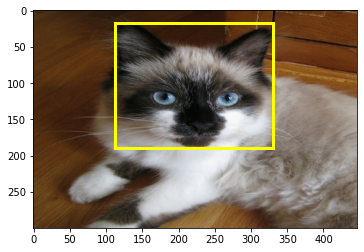

In [ ]:
plot_bb(dataframe['filename'][4], dataframe['bb'][4])

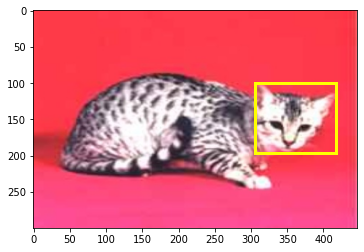

In [ ]:
plot_bb(dataframe['filename'][2], dataframe['bb'][2])

**FUNCTION TO NORMALIZE & SCALE THE IMAGES**

In [ ]:
def normalize_image(image):
    # IMAGENET STATS 
    stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (image - stats[0])/stats[1] 

# SCALE THE IMAGE PIXELS
def scale_image(path):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    return x

**DATASET CLASS TO PASS DATA TO THE MODEL IN BATCHES**

In [ ]:
class Pet(Dataset):
    def __init__(self, paths, bb, y):
        self.paths = paths.values
        self.bb = bb.values
        self.y = y

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        path = self.paths[index]

        x = scale_image(path)
        x = normalize_image(x)
        x = np.rollaxis(x, 2)
        
        y_class = self.y[index]
        y_bb = self.bb[index]
        
        return x, y_class, y_bb

In [ ]:
train_ds = Pet(x_train['filename'], x_train['bb'], y_train)
valid_ds = Pet(x_val['filename'], x_val['bb'], y_val)

**BATCH SIZE FOR TRAINING AND VALIDATION DATA TO LOAD**

In [ ]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

**USING RESNET34 MODEL**

In [ ]:
class ResNetModel(torch.nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()

        #USING RESNET34 PRETRAINED MODEL
        resnet = models.resnet34(pretrained=True)

        #REMOVING THE CLASSIFIER TO CHANGE IT TO OUR PROBLEM STATEMENT 
        layers = list(resnet.children())[:8]

        self.features1 = torch.nn.Sequential(*layers[:6])
        self.features2 = torch.nn.Sequential(*layers[6:])

        #DEFINING THE CLASSIFIER
        self.classifier = torch.nn.Sequential(torch.nn.BatchNorm1d(512), torch.nn.Linear(512, 2)) #Used for detecting classes(cat or dog)
        self.bb = torch.nn.Sequential(torch.nn.BatchNorm1d(512), torch.nn.Linear(512, 4)) #Used for detecting the bounding box coordinates
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        
        x = torch.nn.functional.relu(x)
        x = torch.nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        y_class = torch.nn.functional.sigmoid(self.classifier(x))
        return y_class, self.bb(x)

**TRAINING THE MODEL**

In [ ]:
def train_model(model, optimizer, train_dl, val_dl, epochs, C=100):
  idx = 0
  for i in range(epochs):
    model.train()
    total = 0
    sum_loss = 0

    for x, y_class, y_bb in train_dl:
        batch = y_class.shape[0]

        # IMAGE PIXELS TENSOR
        x = x.cuda().float()

        # CLASS TENSORS
        y_class = y_class.cuda()

        # BB TENSORS
        y_bb = y_bb.cuda().float()

        # LOAD THE TENSORS INTO MODEL AND PREDICT THE CLASS_NAMES AND BB
        out_class, out_bb = model(x)


        # CALCULATE LOSS BETWEEN THE ACTUAL & PREDICTED CLASS 
        loss_class = torch.nn.functional.cross_entropy(out_class, y_class, reduction="sum")

        # CALCULATE LOSS BETWEEN THE ACTUAL & PREDICTED BB COORDINATES
        loss_bb = torch.nn.functional.l1_loss(out_bb, y_bb, reduction="none").sum(1)

        # ADD THE 4 BB LOSSES INTO A SINGLE VALUE
        loss_bb = loss_bb.sum()

        # SCALE THE BB LOSS BY 1000 TO HAVE CLASS LOSS AND BB LOSS IN SAME RANGE
        loss = loss_class + loss_bb/C

        # SET GRADIENTS TO ZERO
        optimizer.zero_grad()

        # BACKPROPOGATE THE LOSS
        loss.backward()

        # UPDATE ALL PARAMETERS
        optimizer.step()

        idx += 1
        total += batch
        sum_loss += loss.item()

    # CALCULATE THE TOTAL TRAINING LOSS
    train_loss = sum_loss/total

    # CALCULATE THE VALIDATION LOSS AND ACCURACY
    val_loss, val_acc = calculate_validation_metrics(model, valid_dl, C)

    print("epoch %d train_loss %.3f val_loss %.3f val_acc %.3f" % (i, train_loss, val_loss, val_acc))

  return sum_loss/total


# FOR CALCULATING VALIDATION LOSS AND ACCURACY
def calculate_validation_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]

        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)

        loss_class = torch.nn.functional.cross_entropy(out_class, y_class, reduction="sum")

        loss_bb = torch.nn.functional.l1_loss(out_bb, y_bb, reduction="none").sum(1)

        loss_bb = loss_bb.sum()

        loss = loss_class + loss_bb/C

        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch

    return sum_loss/total, correct/total

In [ ]:
# CALL MODEL AND SET PARAMETERS
res_model = ResNetModel().cuda()

#GETTING THE MODEL SUMMARY
print(res_model)
parameters = filter(lambda param: param.requires_grad, res_model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.001)

train_model(res_model, optimizer, train_dl, valid_dl, epochs=28)


ResNetModel(
  (features1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch 0 train_loss 7.025 val_loss 7.308 val_acc 0.586
epoch 1 train_loss 6.880 val_loss 6.841 val_acc 0.888
epoch 2 train_loss 6.542 val_loss 6.283 val_acc 0.920
epoch 3 train_loss 5.993 val_loss 5.595 val_acc 0.914
epoch 4 train_loss 5.286 val_loss 5.002 val_acc 0.952
epoch 5 train_loss 4.537 val_loss 5.261 val_acc 0.879
epoch 6 train_loss 3.750 val_loss 3.572 val_acc 0.918
epoch 7 train_loss 3.041 val_loss 2.940 val_acc 0.933
epoch 8 train_loss 2.399 val_loss 2.124 val_acc 0.976
epoch 9 train_loss 1.802 val_loss 1.806 val_acc 0.965
epoch 10 train_loss 1.457 val_loss 1.397 val_acc 0.967
epoch 11 train_loss 1.203 val_loss 1.250 val_acc 0.952
epoch 12 train_loss 1.038 val_loss 1.104 val_acc 0.971
epoch 13 train_loss 0.911 val_loss 0.961 val_acc 0.977
epoch 14 train_loss 0.792 val_loss 0.881 val_acc 0.948
epoch 15 train_loss 0.739 val_loss 0.883 val_acc 0.910
epoch 16 train_loss 0.707 val_loss 0.808 val_acc 0.966
epoch 17 train_loss 0.688 val_loss 0.761 val_acc 0.966
epoch 18 train_loss 

0.6117369504975363

**SAVING THE MODEL**

In [ ]:
print("The state dict keys: \n\n", res_model.state_dict().keys())

The state dict keys: 

 odict_keys(['features1.0.weight', 'features1.1.weight', 'features1.1.bias', 'features1.1.running_mean', 'features1.1.running_var', 'features1.1.num_batches_tracked', 'features1.4.0.conv1.weight', 'features1.4.0.bn1.weight', 'features1.4.0.bn1.bias', 'features1.4.0.bn1.running_mean', 'features1.4.0.bn1.running_var', 'features1.4.0.bn1.num_batches_tracked', 'features1.4.0.conv2.weight', 'features1.4.0.bn2.weight', 'features1.4.0.bn2.bias', 'features1.4.0.bn2.running_mean', 'features1.4.0.bn2.running_var', 'features1.4.0.bn2.num_batches_tracked', 'features1.4.1.conv1.weight', 'features1.4.1.bn1.weight', 'features1.4.1.bn1.bias', 'features1.4.1.bn1.running_mean', 'features1.4.1.bn1.running_var', 'features1.4.1.bn1.num_batches_tracked', 'features1.4.1.conv2.weight', 'features1.4.1.bn2.weight', 'features1.4.1.bn2.bias', 'features1.4.1.bn2.running_mean', 'features1.4.1.bn2.running_var', 'features1.4.1.bn2.num_batches_tracked', 'features1.4.2.conv1.weight', 'features1.4

In [ ]:
checkpoint = {'model': ResNetModel(),
              'state_dict': res_model.state_dict()}

In [ ]:
torch.save(checkpoint, '/content/gdrive/My Drive/Assignment/resnet_34.pth')

**FUNCTION TO LOADING THE MODEL**

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    
    model.eval()
    
    return model

In [ ]:
test_data = pd.read_csv('/content/gdrive/My Drive/Assignment/annotations/test.txt', delim_whitespace=True,header=None,)
test_data.columns = ['image', 'CLASS-ID', 'SPECIES', 'BREED ID'] 
test_data['image'] = test_data['image'].apply(lambda x : str(x)+'.jpg')

In [ ]:
print(test_data.head())
print(len(test_data))

                image  CLASS-ID  SPECIES  BREED ID
0  Abyssinian_201.jpg         1        1         1
1  Abyssinian_202.jpg         1        1         1
2  Abyssinian_204.jpg         1        1         1
3  Abyssinian_205.jpg         1        1         1
4  Abyssinian_206.jpg         1        1         1
3669


**EVALUATING THE MODEL**

In [ ]:
pet_map = {0 :'cat', 1:'dog'}

def identify_pet(image_path, model):
  im = read_image(image_path)

  #CREATING A DATAFRAME OF THE IMAGE READ
  test_ds = Pet(pd.DataFrame([{'path':'{}'.format(image_path)}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])

  x, y_class, y_bb = test_ds[0]
  xx = torch.FloatTensor(x[None,])
  out_class, out_bb = model(xx)
  index = out_class.cpu().data.numpy().argmax()
  confidence = out_class.cpu().data.numpy()[0][index]

  bb_hat = out_bb.detach().cpu().numpy()
  bb_hat = abs(bb_hat)
  plot_bb(image_path, bb_hat[0])
  output = '{}:{}'.format(pet_map[index], confidence)
  print(output)
  return (bb_hat)

**CHECK THE ARCHITECTURE OF THE LOADED MODEL**

In [ ]:
model = load_checkpoint('/content/gdrive/My Drive/Assignment/resnet_34.pth')
print(model)

ResNetModel(
  (features1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

For evaluation purpose I have used the images in ths test.txt 

cat:1.0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


array([[  9.69634 ,  27.222534, 287.98984 , 370.82346 ]], dtype=float32)

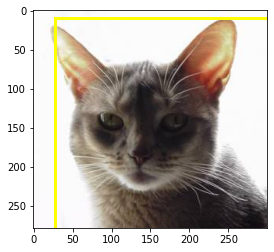

In [ ]:
test_image = test_data['image'][4]
test_img_path = '/content/gdrive/My Drive/Assignment/images/' + test_image
model = load_checkpoint('/content/gdrive/My Drive/Assignment/resnet_34.pth')
identify_pet(test_img_path, model)

cat:1.0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


array([[ 12.700367,  95.12757 , 156.77058 , 248.33653 ]], dtype=float32)

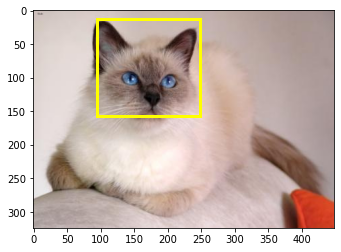

In [ ]:
test_image = test_data['image'][678]
test_img_path = '/content/gdrive/My Drive/Assignment/images/' + test_image
model = load_checkpoint('/content/gdrive/My Drive/Assignment/resnet_34.pth')
identify_pet(test_img_path, model)

cat:0.9994989633560181


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


array([[ 57.783443, 157.55359 , 196.91243 , 315.53796 ]], dtype=float32)

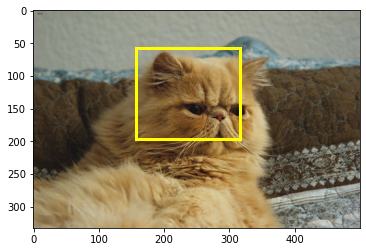

In [ ]:
test_image = test_data['image'][2345]
test_img_path = '/content/gdrive/My Drive/Assignment/images/' + test_image
model = load_checkpoint('/content/gdrive/My Drive/Assignment/resnet_34.pth')
identify_pet(test_img_path, model)

dog:0.9999597072601318


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


array([[ 65.92569, 220.28073, 206.42366, 396.7412 ]], dtype=float32)

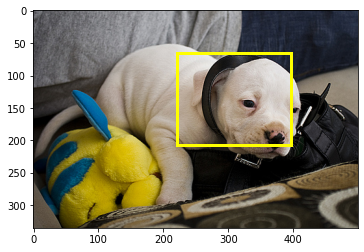

In [ ]:
test_image = test_data['image'][99]
test_img_path = '/content/gdrive/My Drive/Assignment/images/' + test_image
model = load_checkpoint('/content/gdrive/My Drive/Assignment/resnet_34.pth')
identify_pet(test_img_path, model)

dog:0.9999948740005493


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


array([[ 31.653572, 100.27213 , 117.68167 , 179.17458 ]], dtype=float32)

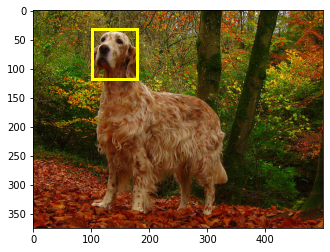

In [ ]:
test_image = test_data['image'][1323]
test_img_path = '/content/gdrive/My Drive/Assignment/images/' + test_image
model = load_checkpoint('/content/gdrive/My Drive/Assignment/resnet_34.pth')
identify_pet(test_img_path, model)

dog:1.0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


array([[ 33.215454, 102.606636, 225.68169 , 365.88684 ]], dtype=float32)

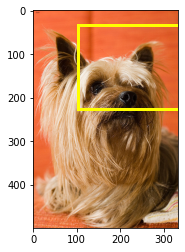

In [ ]:
test_image = test_data['image'][3658]
test_img_path = '/content/gdrive/My Drive/Assignment/images/' + test_image
model = load_checkpoint('/content/gdrive/My Drive/Assignment/resnet_34.pth')
identify_pet(test_img_path, model)

cat:1.0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


array([[  2.035613, 114.49371 , 226.86197 , 367.78897 ]], dtype=float32)

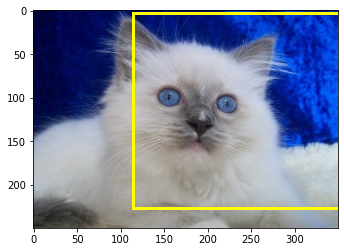

In [ ]:
test_image = test_data['image'][2608]
test_img_path = '/content/gdrive/My Drive/Assignment/images/' + test_image
model = load_checkpoint('/content/gdrive/My Drive/Assignment/resnet_34.pth')
identify_pet(test_img_path, model)

dog:0.9999867677688599


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


array([[ 38.065556, 158.44371 , 149.55109 , 270.2733  ]], dtype=float32)

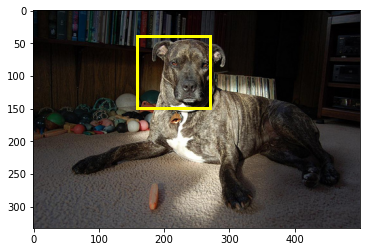

In [ ]:
test_image = test_data['image'][208]
test_img_path = '/content/gdrive/My Drive/Assignment/images/' + test_image
model = load_checkpoint('/content/gdrive/My Drive/Assignment/resnet_34.pth')
identify_pet(test_img_path, model)

dog:0.9999998807907104


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


array([[ 39.20229 ,  42.962906, 245.92943 , 271.93234 ]], dtype=float32)

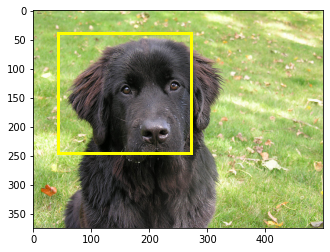

In [ ]:
test_image = test_data['image'][2222]
test_img_path = '/content/gdrive/My Drive/Assignment/images/' + test_image
model = load_checkpoint('/content/gdrive/My Drive/Assignment/resnet_34.pth')
identify_pet(test_img_path, model)

dog:0.9998118281364441


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


array([[ 42.219307, 167.26457 , 135.06506 , 255.47305 ]], dtype=float32)

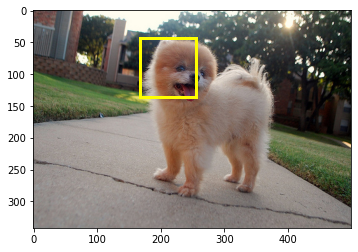

In [ ]:
test_image = test_data['image'][2453]
test_img_path = '/content/gdrive/My Drive/Assignment/images/' + test_image
model = load_checkpoint('/content/gdrive/My Drive/Assignment/resnet_34.pth')
identify_pet(test_img_path, model)

dog:0.9999853372573853


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


array([[ 38.621044,  83.680626, 128.13647 , 202.97072 ]], dtype=float32)

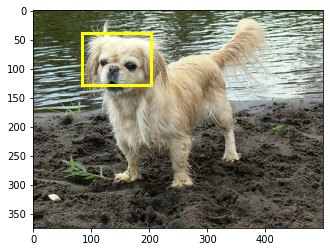

In [ ]:
test_image = test_data['image'][1768]
test_img_path = '/content/gdrive/My Drive/Assignment/images/' + test_image
model = load_checkpoint('/content/gdrive/My Drive/Assignment/resnet_34.pth')
identify_pet(test_img_path, model)

cat:1.0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


array([[  3.6000285,  87.8845   , 216.27708  , 320.72482  ]],
      dtype=float32)

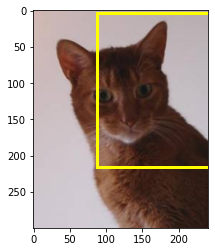

In [ ]:
test_image = test_data['image'][7]
test_img_path = '/content/gdrive/My Drive/Assignment/images/' + test_image
model = load_checkpoint('/content/gdrive/My Drive/Assignment/resnet_34.pth')
identify_pet(test_img_path, model)

Since there are bounding boxes available for test dataset I am using some images from the train_val dataset to calculate iou

**FUNCTION TO CALCULATE THE IOU**

In [ ]:
def bb_intersection_over_union(boxA, boxB):

  #DETERMINING THE MIN & MAX COORDINATES OF THE GROUND TRUTH AND PREDICTED BOUNDING BOXES
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
 
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
 
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	
	return iou

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


cat:1.0
IOU : 0.8512956420747577


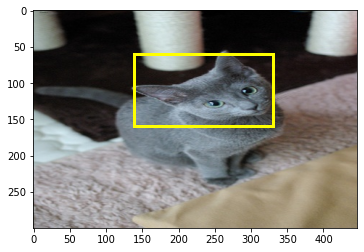

In [ ]:
test_image = dataframe['filename'][100]

bb_true = dataframe['bb'][100]

model = load_checkpoint('/content/gdrive/My Drive/Assignment/resnet_34.pth')
bb_predicted = (identify_pet(test_image, model)).ravel()

iou = bb_intersection_over_union(bb_true, bb_predicted)
print('IOU :', iou)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


cat:0.9999996423721313
IOU : 0.9010282251923911


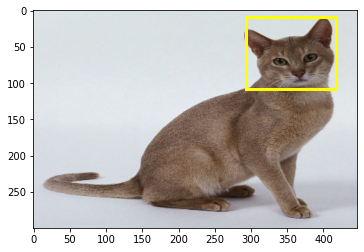

In [ ]:
test_image = dataframe['filename'][3000]

bb_true = dataframe['bb'][3000]

model = load_checkpoint('/content/gdrive/My Drive/Assignment/resnet_34.pth')
bb_predicted = (identify_pet(test_image, model)).ravel()

iou = bb_intersection_over_union(bb_true, bb_predicted)
print('IOU :', iou)

cat:1.0
IOU : 0.6076132180765961


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


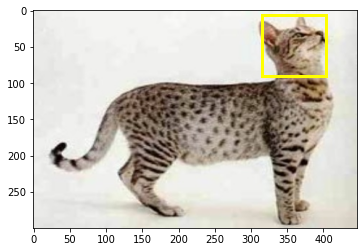

In [ ]:
test_image = dataframe['filename'][245]

bb_true = dataframe['bb'][3000]

model = load_checkpoint('/content/gdrive/My Drive/Assignment/resnet_34.pth')
bb_predicted = (identify_pet(test_image, model)).ravel()

iou = bb_intersection_over_union(bb_true, bb_predicted)
print('IOU :', iou)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


dog:0.9999591112136841
IOU : 0.9474464885900896


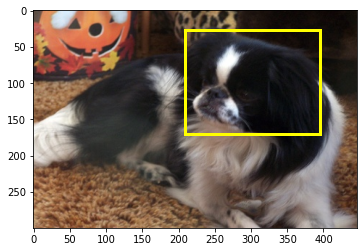

In [ ]:
test_image = dataframe['filename'][3656]

bb_true = dataframe['bb'][3656]

model = load_checkpoint('/content/gdrive/My Drive/Assignment/resnet_34.pth')
bb_predicted = (identify_pet(test_image, model)).ravel()

iou = bb_intersection_over_union(bb_true, bb_predicted)
print('IOU :', iou)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


dog:0.9999289512634277
IOU : 0.9190345404175021


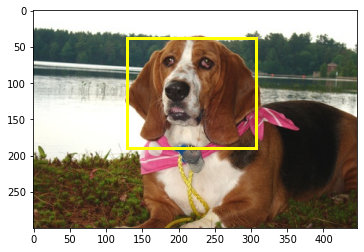

In [ ]:
test_image = dataframe['filename'][3359]

bb_true = dataframe['bb'][3359]

model = load_checkpoint('/content/gdrive/My Drive/Assignment/resnet_34.pth')
bb_predicted = (identify_pet(test_image, model)).ravel()

iou = bb_intersection_over_union(bb_true, bb_predicted)
print('IOU :', iou)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


dog:0.9999972581863403
IOU : 0.8447079407371385


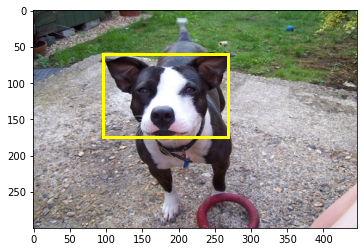

In [ ]:
test_image = dataframe['filename'][1]

bb_true = dataframe['bb'][1]

model = load_checkpoint('/content/gdrive/My Drive/Assignment/resnet_34.pth')
bb_predicted = (identify_pet(test_image, model)).ravel()

iou = bb_intersection_over_union(bb_true, bb_predicted)
print('IOU :', iou)